In [8]:
# Install necessary packages
#!pip install pytrials transformers sklearn matplotlib

In [9]:
# Import necessary libraries
from pytrials.client import ClinicalTrials
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [10]:
# Initialize ClinicalTrials client
ct = ClinicalTrials()

# Check valid fields
#print("Valid fields:", ct.study_fields["json"])
#print(ct.study_fields)

In [11]:
# Define a function to fetch clinical trial abstracts for given conditions
def fetch_abstracts(conditions, max_results=1000):
    abstracts = []
    for condition in conditions:
        results = ct.get_study_fields(
            search_expr=condition, 
            fields=[
                    #"Study Title",
                    #"Study Type",
                    "Brief Summary"
            ],  # Add NCTId to see if BriefSummary is causing issues
            max_studies=max_results # Ensure we don't request more than 1000 studies
        )
        abstracts.append(results)

            
    return abstracts

In [12]:
# Fetch abstracts for a few popular clinical trial areas
conditions = ["Cancer+Oncology+Tumor+Neoplasm+Carcinoma+Malignancy", # Cancer Keyword Collection
              "Diabetes+Diabetes Mellitus+Hyperglycemia+Insulin+Blood Sugar+Glucose",  # Diabetes Keyword Collection
              "Coronavirus+COVID+SARS-CoV-2+Pandemic+Virus+Infection" # COVID Keyword Collection
             ]

abstracts = fetch_abstracts(conditions,max_results=1000)

In [13]:
#print(abstracts)
print(type(abstracts))
print(len(abstracts))
#print(abstracts)

<class 'list'>
3


In [14]:
abstracts_0 = abstracts[0]
abstracts_1 = abstracts[1]
abstracts_2 = abstracts[2]

In [15]:
print(len(abstracts_0))
print(len(abstracts_1))
print(len(abstracts_2))

1001
1001
1001


In [16]:
ab0 = abstracts_0[1:101]
ab1 = abstracts_1[1:101]
ab2 = abstracts_2[1:101]

In [17]:
full_abs = ab0 + ab1 + ab2
flattened_abs = [text for sublist in full_abs for text in sublist]
len(flattened_abs)

300

In [18]:
#partial_abs = ab0[0:10] + ab1[0:10] + ab2[0:10]
#flattened_partial_abs = [text for sublist in partial_abs for text in sublist]
#len(flattened_partial_abs)

In [19]:
# Load PubMedBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [20]:
# Function to get embeddings from PubMedBERT
def get_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [22]:
# Ensure that the device is set to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to process a single batch
def process_batch(batch_texts, tokenizer, model, device):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return batch_embeddings

# Function to get embeddings from PubMedBERT in parallel
def get_embeddings_parallel(texts, tokenizer, model, batch_size=8, num_workers=4):
    # Split texts into batches
    batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
    
    embeddings = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Submit tasks to the executor
        future_to_batch = {executor.submit(process_batch, batch, tokenizer, model, device): batch for batch in batches}
        
        for future in as_completed(future_to_batch):
            batch_embeddings = future.result()
            embeddings.append(batch_embeddings)
    
    # Combine the embeddings from all batches
    embeddings = np.vstack(embeddings)
    return embeddings


In [24]:
# Get embeddings for the abstracts
# Erika's note: took 5 min for this to load.. any way to make it faster?
embeddings = get_embeddings_parallel(flattened_abs, tokenizer, model, batch_size=8, num_workers=6)

In [26]:
# Adjust perplexity to be less than the number of samples
perplexity_value = min(embeddings.shape[0] - 1, 30)  # Use the minimum of number of samples - 1 or 30

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)

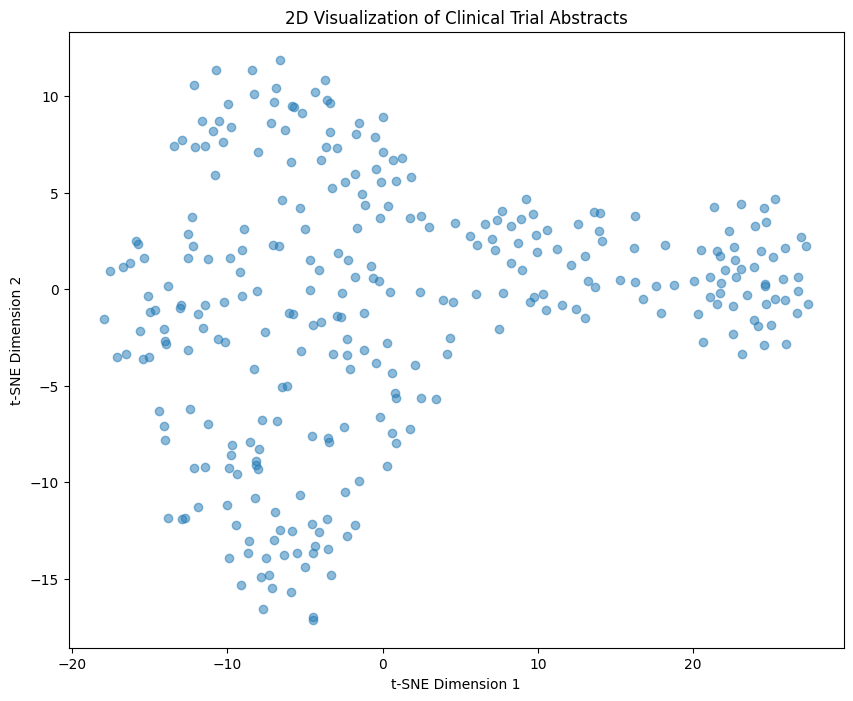

In [27]:
# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title("2D Visualization of Clinical Trial Abstracts")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [28]:
# Create labels for the points
#num_samples = embeddings.shape[0]
#labels = ['Cancer'] * (num_samples // 3) + ['Diabetes'] * (num_samples // 3) + ['COVID related'] * (num_samples - 2 * (num_samples // 3))

In [4]:
# input text from document that already went through unstructured

extractedText = """
This is a try for the biomedical entity extraction. Here are some biomedical words: Cancer and Diabetes and Pneumonia
"""
print(extractedText)


This is a try for the biomedical entity extraction. Here are some biomedical words: Cancer and Diabetes and Pneumonia



In [5]:
## SETUP WITH INPUT TEXT

import requests
import json

text = extractedText

headers={
    'content-type': 'text/plain'
}

url = 'https://lexica.pfizer.com/ks/umls/metamap'
res = requests.post(url, verify=False, headers=headers, data=text.encode('utf-8'))
res.raise_for_status()


c:\Users\vonkie\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lexica.pfizer.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [6]:
## FINISHED BIOMEDICAL SORTER (w/ comments)

keywordList = ['aapp', 'amas', 'anab', 'anst', 'antb', 'bacs', 'bact', 'bdsu',
               'bdsy', 'biof', 'blor', 'bmod', 'bodm', 'bpoc', 'bsoj', 'celc',
               'celf', 'cell', 'cgab', 'chem', 'chvf', 'chvs', 'clas',
               'clnd','comd', 'drdd', 'dsyn', 'eehu', 'elii', 'emod',
               'emst', 'enzy', 'euka', 'ffas', 'genf', 'gngm', 'hcpp', 'horm',
               'imft', 'irda', 'lbpr', 'lbtr', 'mbrt', 'moft',
               'mosq', 'neop', 'nnon', 'nusq', 'orch', 'orga', 'orgf', 'orgm',
               'ortf', 'patf', 'phsf', 'phsu', 'rcpt', 'sosy', 'tisu',
               'virs', 'vita', 'vrbt',
               # taken away: 'cnce', 'clna', 'inch', 'medd', 'fndg'
               # added: 
               'topp']
data = res.json()['utteranceList']

n = 0
usedList = []
notUsedList = []

for d in data:
    pcmlist = d['pcmlist']
    for pcm in pcmlist:
        maplist = pcm['mappingList']
        for map in maplist:
            evlist = map['evList']
            for ev in evlist:
                semType = ev['semanticTypes']
                word = ev['conceptName'].lower()
                
                listofST = "".join(ev['semanticTypes'])
                
                if (listofST in keywordList
                    or (len(semType) > 1 
                        and (semType[0] in keywordList or semType[1] in keywordList))):
                    
                    # print('found it:', semType, ", ", word, ", ", n)
                    # print('length of type:', len(semType))
                    # print('first semType:', semType[0])
                    # if len(semType) > 1:
                    #     print('second semType:', semType[1])
                    # print('-----')
                    
                    if word in usedList:
                        pass
                    else:
                        usedList.append(word)
                        
                else:
                        
                    # print('not found:', semType, ", ", word, ", ", n)
                    # print('listofST:', listofST)
                    # print('length of type:', len(semType))
                    # print('first semType:', semType[0])
                    # if len(semType) > 1:
                    #     print('second semType:', semType[1])
                    # print('-----')
                    
                    if word in notUsedList:
                        pass
                    else:
                        notUsedList.append(word)
                    
                n = n + 1

print('Biomedical word list:')
print(*usedList, sep = "\n",)
print('------')
print('\n')

print('not used word list:')
print(*notUsedList, sep = "\n")
print('------')

Biomedical word list:
biomedical
extraction
cancer
diabetes
pneumonia
------


not used word list:
entity
word
------


In [32]:
# accessing the biomedical extracted words

firstBioWord = usedList[3]
secondBioWord = usedList[4]
thirdBioWord = usedList[5]

print(firstBioWord, ", ", secondBioWord, ", ", thirdBioWord)

cancer ,  diabetes ,  pneumonia


In [33]:
# Create labels for the points
num_samples = embeddings.shape[0]
labels = [firstBioWord] * (num_samples // 3) + [secondBioWord] * (num_samples // 3) + [thirdBioWord] * (num_samples - 2 * (num_samples // 3))

In [34]:
len(labels)

300

In [35]:
# Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame({
    't-SNE Dimension 1': embeddings_2d[:, 0],
    't-SNE Dimension 2': embeddings_2d[:, 1],
    'Label': labels
})

In [36]:
# Create interactive plot with Plotly
fig = px.scatter(df, x='t-SNE Dimension 1', y='t-SNE Dimension 2', color='Label', title='2D Visualization of Clinical Trial Abstracts')

# Update the layout for better aesthetics and remove axis ticks
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    font=dict(size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    autosize=True,
    width=800,
    height=600,
    legend=dict(title="Category", orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Show the plot
fig.show()

#pio.write_image(fig, 'tsne_visualization.png', scale=3)

In [3]:
import seaborn as sns
df = sns.load_dataset("penguins")
sns.pairplot(df, hue="species")

ModuleNotFoundError: No module named 'seaborn'

In [37]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

ModuleNotFoundError: No module named 'seaborn'